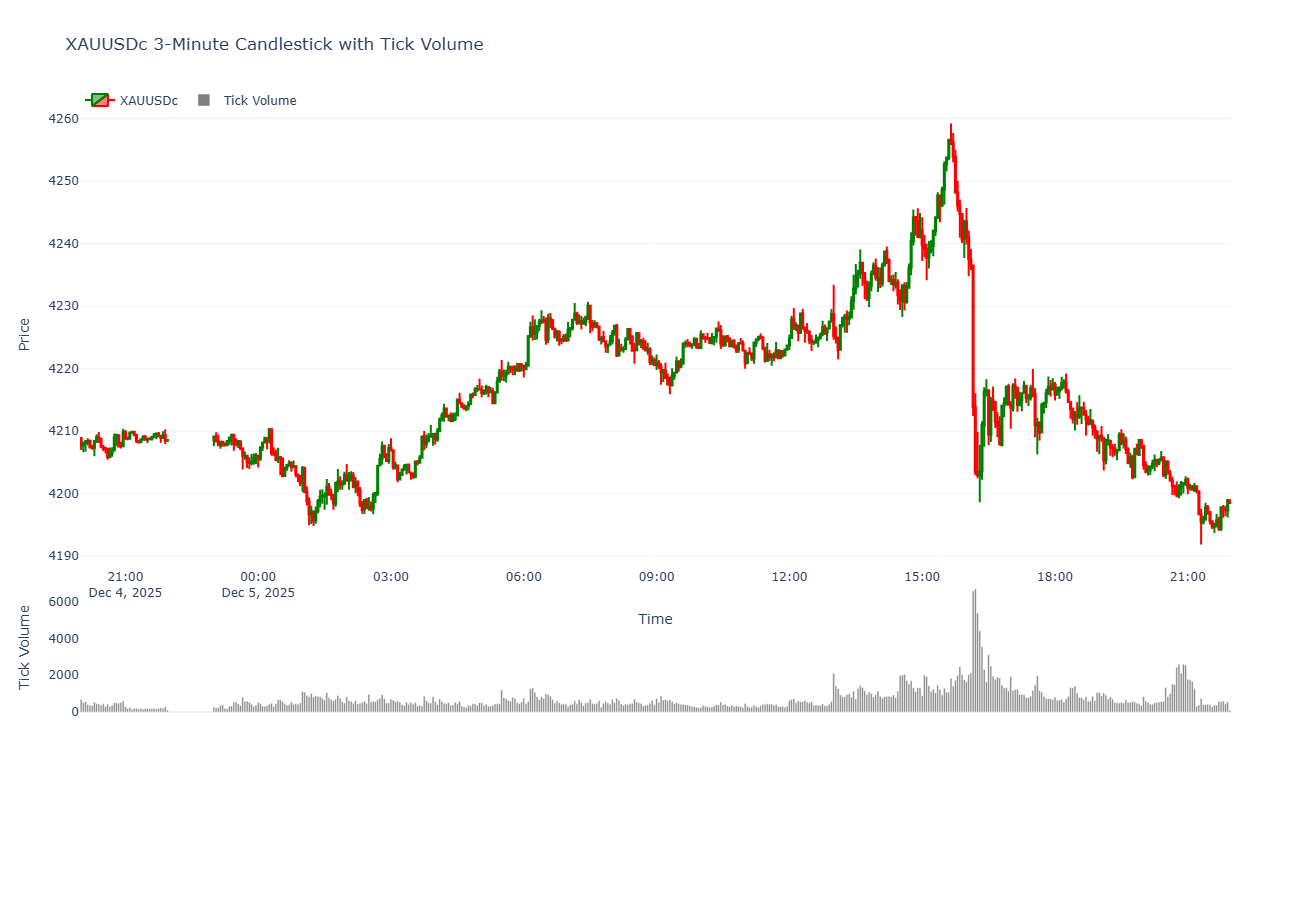

In [1]:
import MetaTrader5 as mt5 
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=3)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove non-trading periods (weekends)
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Plot 3-pane chart (NO HIGHLIGHTS)
# -------------------------
fig = go.Figure()

# Candlestick chart (top pane)
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='XAUUSDc',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Tick-volume bars (middle pane)
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color='gray',
    yaxis='y2'
))

# Layout
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc 3-Minute Candlestick with Tick Volume',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),
    yaxis=dict(title='Price', domain=[0.35, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.15, 0.33], showgrid=False),
    legend=dict(orientation='h', y=1.02, x=0),
    height=900
)

fig.show()


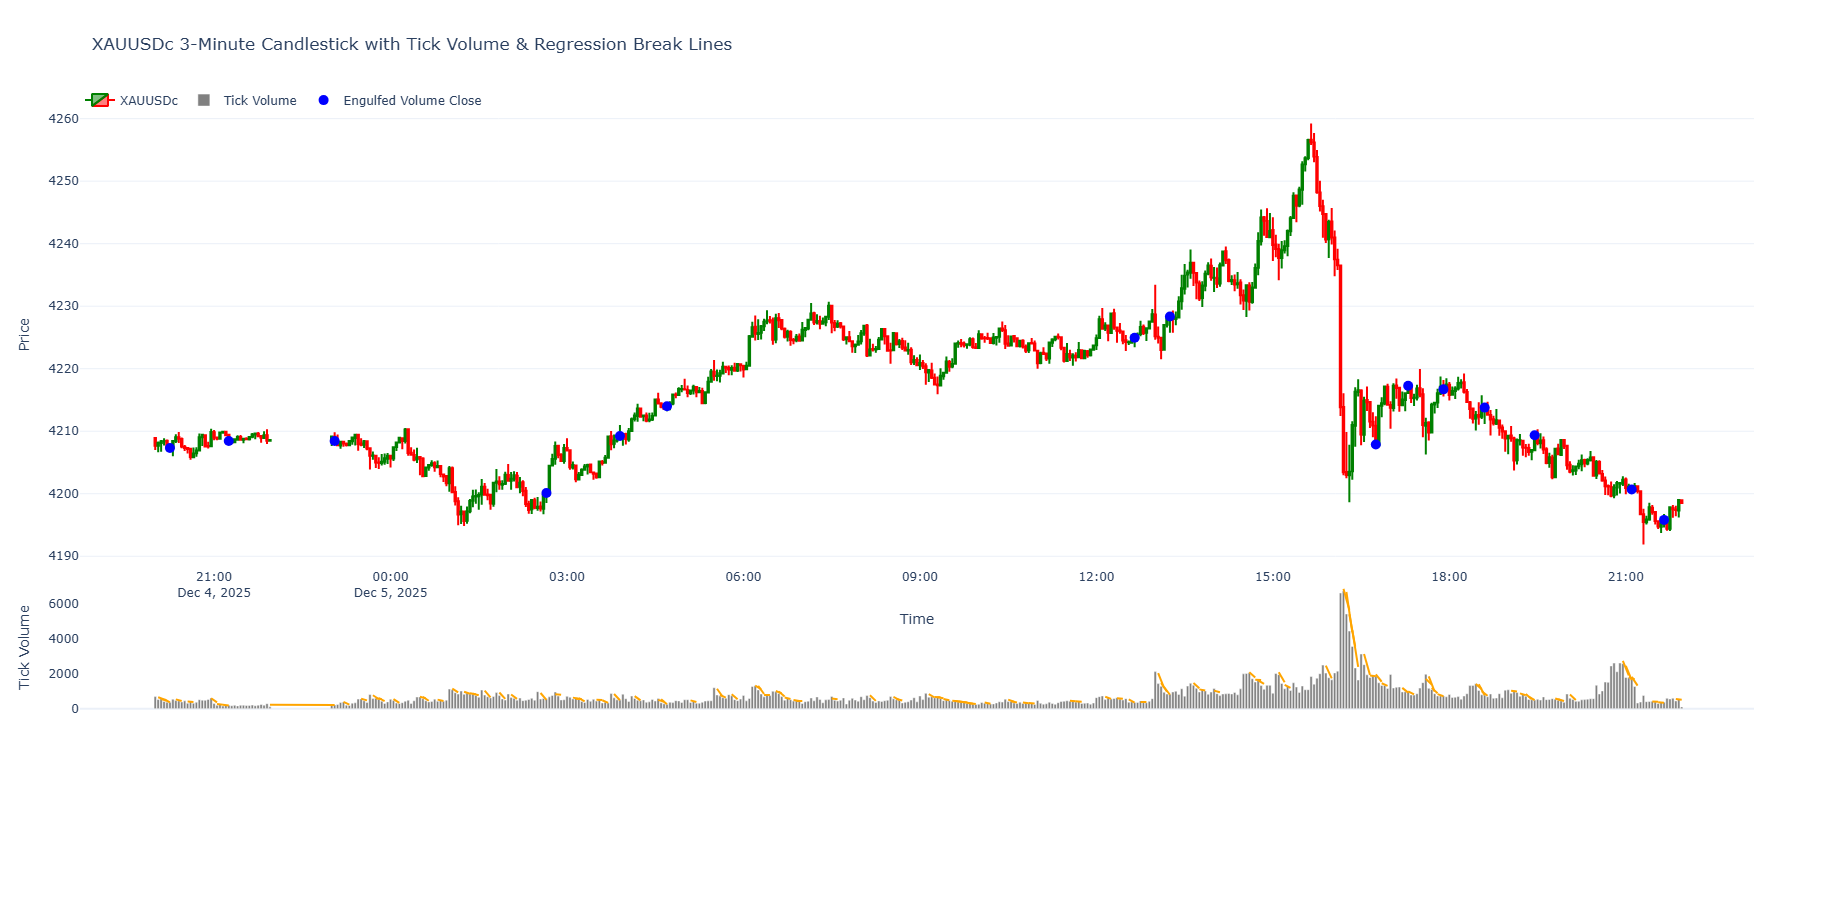

In [8]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta
from scipy.stats import linregress

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=3)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)
df = df[df.index.dayofweek < 5]  # remove weekends

# -------------------------
# 4. Linear Regression on tick volume (decreasing only)
# -------------------------
lookback = 3  # number of bars to calculate regression
df['engulf_signal'] = np.nan
slope_segments = []

for i in range(lookback, len(df)):
    # Only consider decreasing tick volume
    if df['tick_volume'].iloc[i] < df['tick_volume'].iloc[i-1]:
        y = df['tick_volume'].iloc[i-lookback:i].values
        x = np.arange(lookback)
        slope, intercept, _, _, _ = linregress(x, y)
        
        # Only plot down-slopes
        if slope < 0:
            # Store segment start/end and y-values for break line
            segment = {
                'x': df.index[i-lookback+1:i+1],
                'y': intercept + slope * x
            }
            slope_segments.append(segment)
            
            # Check if current tick volume engulfs regression line
            expected_volume = intercept + slope * (lookback-1)
            if df['tick_volume'].iloc[i] > expected_volume:
                df.at[df.index[i], 'engulf_signal'] = df['close'].iloc[i]

# -------------------------
# 5. Plot chart
# -------------------------
fig = go.Figure()

# Candlestick chart
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='XAUUSDc',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Tick-volume bars
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color='gray',
    yaxis='y2'
))

# Plot slope break lines
for seg in slope_segments:
    fig.add_trace(go.Scatter(
        x=seg['x'],
        y=seg['y'],
        mode='lines',
        line=dict(color='orange', width=2),
        name='Down Slope Regression',
        yaxis='y2',
        showlegend=False
    ))

# Highlight engulfed candlestick closes
engulf_idx = df['engulf_signal'].dropna().index
engulf_vals = df['engulf_signal'].dropna().values
fig.add_trace(go.Scatter(
    x=engulf_idx,
    y=engulf_vals,
    mode='markers',
    marker=dict(color='blue', size=10, symbol='circle'),
    name='Engulfed Volume Close'
))

# Layout
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc 3-Minute Candlestick with Tick Volume & Regression Break Lines',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),
    yaxis=dict(title='Price', domain=[0.35, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.15, 0.33], showgrid=False),
    legend=dict(orientation='h', y=1.02, x=0),
    height=900
)

fig.show()


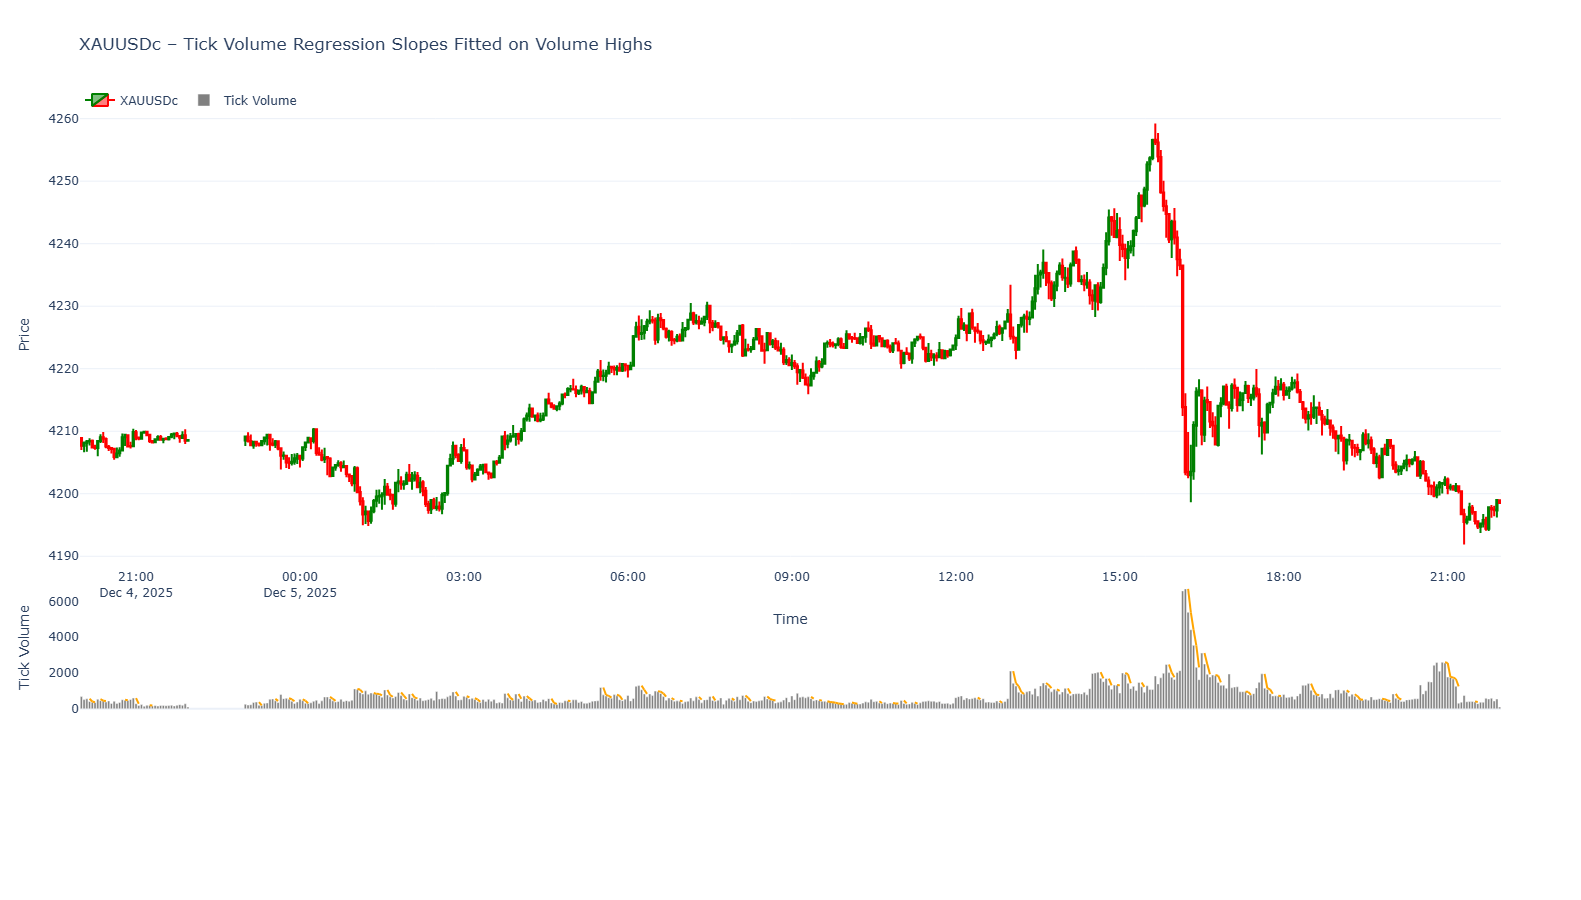

In [10]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta
from scipy.stats import linregress

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=3)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)
df = df[df.index.dayofweek < 5]  # remove weekends

# -------------------------
# 4. Linear Regression Slope (fitted on TOPS of volume bars)
# -------------------------
lookback = 2
df['engulf_signal'] = np.nan
slope_segments = []

for i in range(lookback, len(df)):

    # Only apply regression when volume is decreasing on the last bar
    if df['tick_volume'].iloc[i] < df['tick_volume'].iloc[i-1]:

        # Fit regression on the TOPS of the volume bars
        y = df['tick_volume'].iloc[i-lookback:i].values  # "highs" of volume bars
        x = np.arange(lookback)

        slope, intercept, _, _, _ = linregress(x, y)

        # Only consider downwards slopes
        if slope < 0:

            # Store break-line segment
            segment_x = df.index[i-lookback+1:i+1]
            segment_y = intercept + slope * x
            slope_segments.append({
                'x': segment_x,
                'y': segment_y
            })

            # Engulf check (volume top exceeds the fitted line)
            fitted_last = intercept + slope * (lookback - 1)
            if df['tick_volume'].iloc[i] > fitted_last:
                df.at[df.index[i], 'engulf_signal'] = df['close'].iloc[i]

# -------------------------
# 5. Plot chart
# -------------------------
fig = go.Figure()

# Candlesticks
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='XAUUSDc',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Tick volume bars
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color='gray',
    yaxis='y2'
))

# Down-slope regression BREAK LINES on volume highs
for seg in slope_segments:
    fig.add_trace(go.Scatter(
        x=seg['x'],
        y=seg['y'],
        mode='lines',
        line=dict(color='orange', width=2),
        yaxis='y2',
        showlegend=False
    ))

# Engulfed candlestick closes
engulf_idx = df['engulf_signal'].dropna().index
engulf_vals = df['engulf_signal'].dropna().values

fig.add_trace(go.Scatter(
    x=engulf_idx,
    y=engulf_vals,
    mode='markers',
    marker=dict(color='blue', size=10, symbol='circle'),
    name='Engulfed Volume Close'
))

# Layout
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc – Tick Volume Regression Slopes Fitted on Volume Highs',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),
    yaxis=dict(title='Price', domain=[0.35, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.15, 0.33], showgrid=False),
    legend=dict(orientation='h', y=1.02, x=0),
    height=900
)

fig.show()


overfit these linear regression slope, auto adjust and make it as straight line until a pronounced engulfing

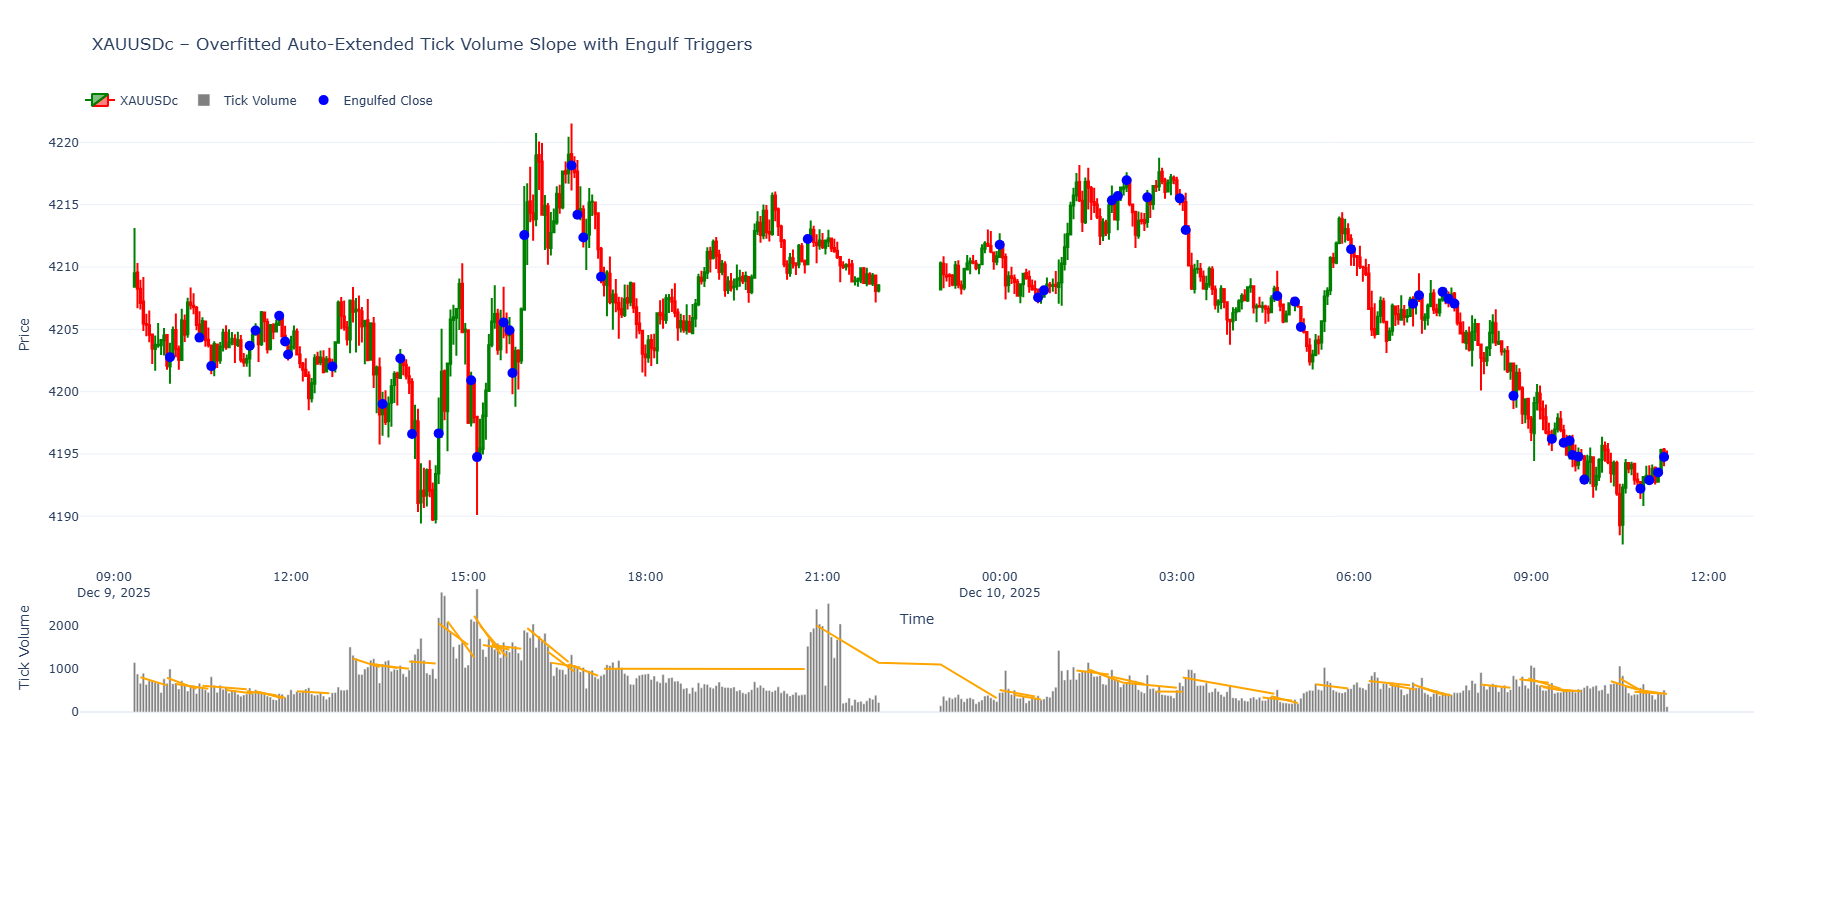

In [17]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta
from scipy.stats import linregress

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=0)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)
df = df[df.index.dayofweek < 5]

# -------------------------
# 4. Overfitted slope system
# -------------------------
lookback = 10

active_slope = None
active_intercept = None
active_start_index = None
active_segment_x = []
active_segment_y = []
segments = []

df['engulf_signal'] = np.nan

for i in range(lookback, len(df)):

    tv_now = df['tick_volume'].iloc[i]
    tv_prev = df['tick_volume'].iloc[i-1]

    # -------------------------
    # CASE 1: No active slope yet
    # -------------------------
    if active_slope is None:

        # Only seed slope when decreasing
        if tv_now < tv_prev:

            y = df['tick_volume'].iloc[i-lookback:i].values
            x = np.arange(lookback)

            slope, intercept, _, _, _ = linregress(x, y)

            if slope < 0:
                active_slope = slope
                active_intercept = intercept
                active_start_index = i - lookback + 1

                active_segment_x = [df.index[j] for j in range(active_start_index, i+1)]
                active_segment_y = list(intercept + slope * np.arange(len(active_segment_x)))

    # -------------------------
    # CASE 2: We have an active slope (auto-extend)
    # -------------------------
    else:
        bars_extended = len(active_segment_x)
        fitted_value_now = active_intercept + active_slope * bars_extended

        if tv_now <= fitted_value_now:
            active_segment_x.append(df.index[i])
            active_segment_y.append(fitted_value_now)
        else:
            segments.append({
                'x': active_segment_x.copy(),
                'y': active_segment_y.copy()
            })

            df.at[df.index[i], 'engulf_signal'] = df['close'].iloc[i]

            active_slope = None
            active_intercept = None
            active_start_index = None
            active_segment_x = []
            active_segment_y = []

            if tv_now < tv_prev:
                y = df['tick_volume'].iloc[i-lookback:i].values
                x = np.arange(lookback)
                slope, intercept, _, _, _ = linregress(x, y)
                if slope < 0:
                    active_slope = slope
                    active_intercept = intercept
                    active_start_index = i - lookback + 1
                    active_segment_x = [df.index[j] for j in range(active_start_index, i+1)]
                    active_segment_y = list(intercept + slope * np.arange(len(active_segment_x)))

# Push last active segment if unfinished
if active_slope is not None and len(active_segment_x) > 0:
    segments.append({'x': active_segment_x, 'y': active_segment_y})


# -------------------------
# 5. Plot chart
# -------------------------
fig = go.Figure()

# Candlesticks
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='XAUUSDc',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Tick volume bars
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color='gray',
    yaxis='y2'
))

# Plot overfitted straight-line slopes
for seg in segments:
    fig.add_trace(go.Scatter(
        x=seg['x'],
        y=seg['y'],
        mode='lines',
        line=dict(color='orange', width=2),
        yaxis='y2',
        showlegend=False
    ))

# Engulf markers
engulf_idx = df['engulf_signal'].dropna().index
engulf_vals = df['engulf_signal'].dropna().values

fig.add_trace(go.Scatter(
    x=engulf_idx,
    y=engulf_vals,
    mode='markers',
    marker=dict(color='blue', size=10, symbol='circle'),
    name='Engulfed Close'
))

# Layout
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc – Overfitted Auto-Extended Tick Volume Slope with Engulf Triggers',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),
    yaxis=dict(title='Price', domain=[0.35, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.15, 0.33], showgrid=False),
    legend=dict(orientation='h', y=1.02, x=0),
    height=900
)

fig.show()
